#### **Preprocessing Data (Menyeimbangkan Data menggunakan SMOTE) Data Bank**

#### - Koneksi Ke Database

In [2]:
import pandas as pd

import mysql.connector

# Koneksi ke MySQL database
conn = mysql.connector.connect(
  host='localhost',
  user='root',
  password='',
  database='bank'
)

# Ambil nama kolom
cursor = conn.cursor()
cursor.execute("SHOW COLUMNS FROM bank")
columns = cursor.fetchall()

# Ambil seluruh isi tabel
df_iris = pd.read_sql("SELECT * FROM bank", conn)
print("\nIsi tabel bank:")
print(df_iris)

# Tutup koneksi
conn.close()


Isi tabel bank:
      age            job  marital  education default  balance housing loan  \
0      30     unemployed  married    primary      no     1787      no   no   
1      33       services  married  secondary      no     4789     yes  yes   
2      35     management   single   tertiary      no     1350     yes   no   
3      30     management  married   tertiary      no     1476     yes  yes   
4      59    blue-collar  married  secondary      no        0     yes   no   
...   ...            ...      ...        ...     ...      ...     ...  ...   
4516   33       services  married  secondary      no     -333     yes   no   
4517   57  self-employed  married   tertiary     yes    -3313     yes  yes   
4518   57     technician  married  secondary      no      295      no   no   
4519   28    blue-collar  married  secondary      no     1137      no   no   
4520   44   entrepreneur   single   tertiary      no     1136     yes  yes   

       contact  day month  duration  campaign 

C:\Users\ahabi\AppData\Local\Temp\ipykernel_29720\1194890474.py:19: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_iris = pd.read_sql("SELECT * FROM bank", conn)


#### - Visualisi Data menggunakan PCA

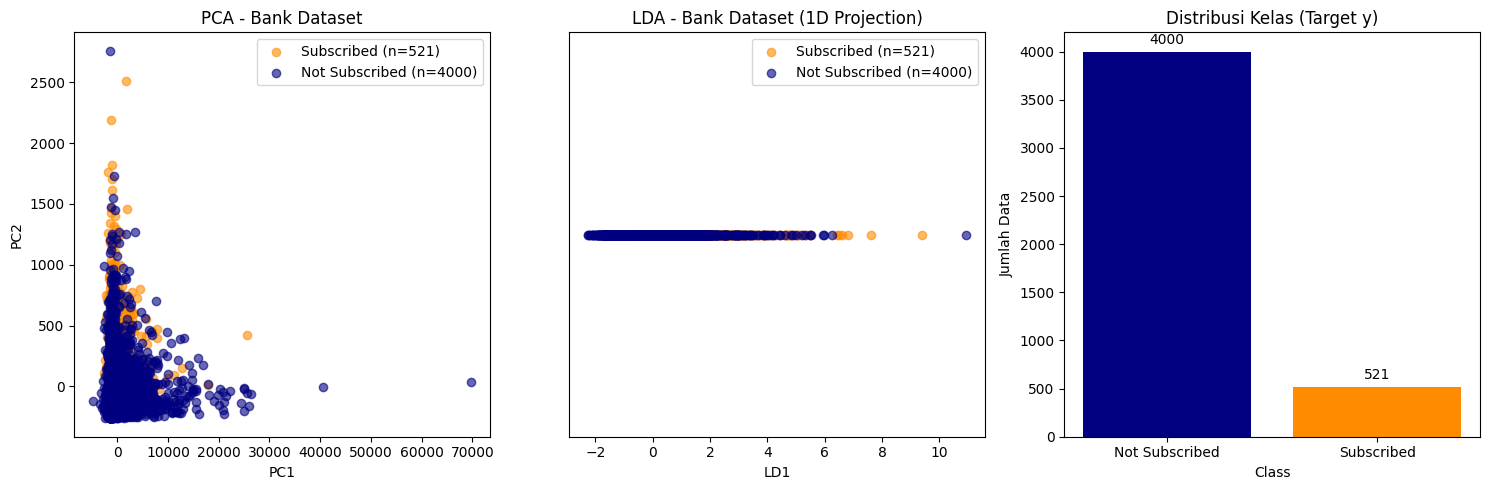


Explained variance ratio (PCA): [0.99149726 0.0073897 ]


In [3]:
# --- VISUALISASI DATA BANK (PCA, LDA, DAN DISTRIBUSI KELAS) ---
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import numpy as np

# Duplikat dataframe (biar aman)
df_bank = df_iris.copy()

# ==========================
# 1. PRA-PROSES DATA
# ==========================
# Pisahkan fitur numerik dan kategorikal
numeric_cols = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']

# Encode data kategorikal
le = LabelEncoder()
for col in categorical_cols:
    df_bank[col] = le.fit_transform(df_bank[col])

# Encode label target (kolom y)
df_bank['y'] = df_bank['y'].map({'yes': 1, 'no': 0})

# Siapkan data fitur dan target
X_db = df_bank[numeric_cols + categorical_cols].values
y_db = df_bank['y'].values

# ==========================
# 2. PCA DAN LDA
# ==========================
pca_db = PCA(n_components=2)
X_r_db = pca_db.fit_transform(X_db)

lda_db = LinearDiscriminantAnalysis(n_components=1)
X_r2_db = lda_db.fit_transform(X_db, y_db)

# ==========================
# 3. VISUALISASI
# ==========================
plt.figure(figsize=(15, 5))
colors = ['darkorange', 'navy']

# --- Plot PCA ---
plt.subplot(1, 3, 1)
for color, i, target_name in zip(colors, [1, 0], ['Subscribed', 'Not Subscribed']):
    mask = y_db == i
    plt.scatter(X_r_db[mask, 0], X_r_db[mask, 1], color=color, alpha=0.6,
                label=f"{target_name} (n={np.sum(mask)})")
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("PCA - Bank Dataset")
plt.xlabel("PC1")
plt.ylabel("PC2")

# --- Plot LDA ---
plt.subplot(1, 3, 2)
for color, i, target_name in zip(colors, [1, 0], ['Subscribed', 'Not Subscribed']):
    mask = y_db == i
    plt.scatter(X_r2_db[mask, 0], np.zeros_like(X_r2_db[mask]), color=color, alpha=0.6,
                label=f"{target_name} (n={np.sum(mask)})")
plt.legend(loc="best", shadow=False, scatterpoints=1)
plt.title("LDA - Bank Dataset (1D Projection)")
plt.xlabel("LD1")
plt.yticks([])

# --- Plot distribusi kelas ---
plt.subplot(1, 3, 3)
class_counts = df_bank['y'].value_counts()
plt.bar(['Not Subscribed', 'Subscribed'], class_counts.values, color=['navy', 'darkorange'])
plt.title("Distribusi Kelas (Target y)")
plt.xlabel("Class")
plt.ylabel("Jumlah Data")
for i, v in enumerate(class_counts.values):
    plt.text(i, v + 50, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"\nExplained variance ratio (PCA): {pca_db.explained_variance_ratio_}")


#### - Menggunakan SMOTE untuk penyeimbangan Data

C:\Users\ahabi\AppData\Local\Temp\ipykernel_29720\3287878904.py:22: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM bank", conn)


=== ANALISIS DATA SEBELUM SMOTE ===
Distribusi kelas sebelum SMOTE:
Counter({0: 4000, 1: 521})
Total sampel sebelum SMOTE: 4521
Jumlah fitur: 16

=== ANALISIS DATA SETELAH SMOTE ===
Distribusi kelas setelah SMOTE:
Counter({0: 4000, 1: 4000})
Total sampel setelah SMOTE: 8000


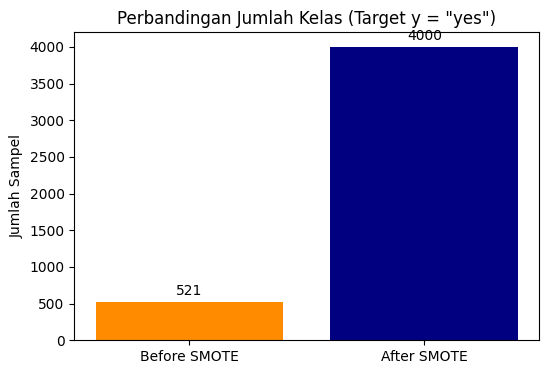

In [5]:
# === PENYEIMBANGAN DATA BANK MENGGUNAKAN SMOTE ===

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mysql.connector
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import LabelEncoder

# ==========================
# 1. KONEKSI KE DATABASE
# ==========================
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='',
    database='bank'   # ganti sesuai nama database kamu
)

# Ambil seluruh data dari tabel bank
df = pd.read_sql("SELECT * FROM bank", conn)
conn.close()

# ==========================
# 2. PRA-PROSES DATA
# ==========================
# Encode kolom kategorikal agar bisa diolah SMOTE
categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                    'loan', 'contact', 'month', 'poutcome']

le = LabelEncoder()
for col in categorical_cols:
    df[col] = le.fit_transform(df[col])

# Encode label target (yes/no → 1/0)
df['y'] = df['y'].map({'yes': 1, 'no': 0})

# ==========================
# 3. PERSIAPAN DATA UNTUK SMOTE
# ==========================
X = df.drop('y', axis=1)  # Fitur
y = df['y']               # Target

print("=== ANALISIS DATA SEBELUM SMOTE ===")
print("Distribusi kelas sebelum SMOTE:")
print(Counter(y))
print(f"Total sampel sebelum SMOTE: {len(y)}")
print(f"Jumlah fitur: {X.shape[1]}")

# ==========================
# 4. SMOTE
# ==========================
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("\n=== ANALISIS DATA SETELAH SMOTE ===")
print("Distribusi kelas setelah SMOTE:")
print(Counter(y_resampled))
print(f"Total sampel setelah SMOTE: {len(y_resampled)}")

# ==========================
# 5. VISUALISASI DISTRIBUSI KELAS
# ==========================
plt.figure(figsize=(6, 4))
plt.bar(['Before SMOTE', 'After SMOTE'], [Counter(y)[1], Counter(y_resampled)[1]], 
        color=['darkorange', 'navy'])
plt.title('Perbandingan Jumlah Kelas (Target y = "yes")')
plt.ylabel('Jumlah Sampel')
for i, v in enumerate([Counter(y)[1], Counter(y_resampled)[1]]):
    plt.text(i, v + 50, str(v), ha='center', va='bottom')
plt.show()



In [8]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

# === PENERAPAN SMOTE ===
print("\n=== PENERAPAN SMOTE ===")

# Pisahkan fitur dan target
X = df.drop('y', axis=1)     # ganti 'y' dengan nama kolom target kamu
y = df['y']

# Jika ada kolom kategorikal, ubah ke numerik dulu (One-Hot Encoding)
X_encoded = pd.get_dummies(X, drop_first=True)

# Inisialisasi SMOTE
smote = SMOTE(random_state=42)

# Terapkan SMOTE
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

print("Distribusi kelas setelah SMOTE:")
print(Counter(y_resampled))
print(f"Total sampel setelah SMOTE: {len(y_resampled)}")

# Konversi hasil SMOTE ke DataFrame baru
df_resampled = pd.DataFrame(X_resampled, columns=X_encoded.columns)
df_resampled['y'] = y_resampled

print("\nContoh data sintetis yang dihasilkan SMOTE:")
print(df_resampled.tail(10))



=== PENERAPAN SMOTE ===
Distribusi kelas setelah SMOTE:
Counter({0: 4000, 1: 4000})
Total sampel setelah SMOTE: 8000

Contoh data sintetis yang dihasilkan SMOTE:
      age  job  marital  education  default  balance  housing  loan  contact  \
7990   58    6        0          1        0      462        0     0        0   
7991   33    5        0          1        0      887        1     0        0   
7992   45    0        1          1        0     2388        1     0        0   
7993   51    8        1          1        0     2248        0     0        0   
7994   41    0        0          1        0      943        0     0        0   
7995   54    4        1          1        0     2759        0     0        0   
7996   34    8        0          1        0      959        0     0        0   
7997   41    3        1          1        0      523        1     0        1   
7998   57    4        0          2        0        0        0     0        0   
7999   27    1        2          1   


=== VISUALISASI HASIL SMOTE ===


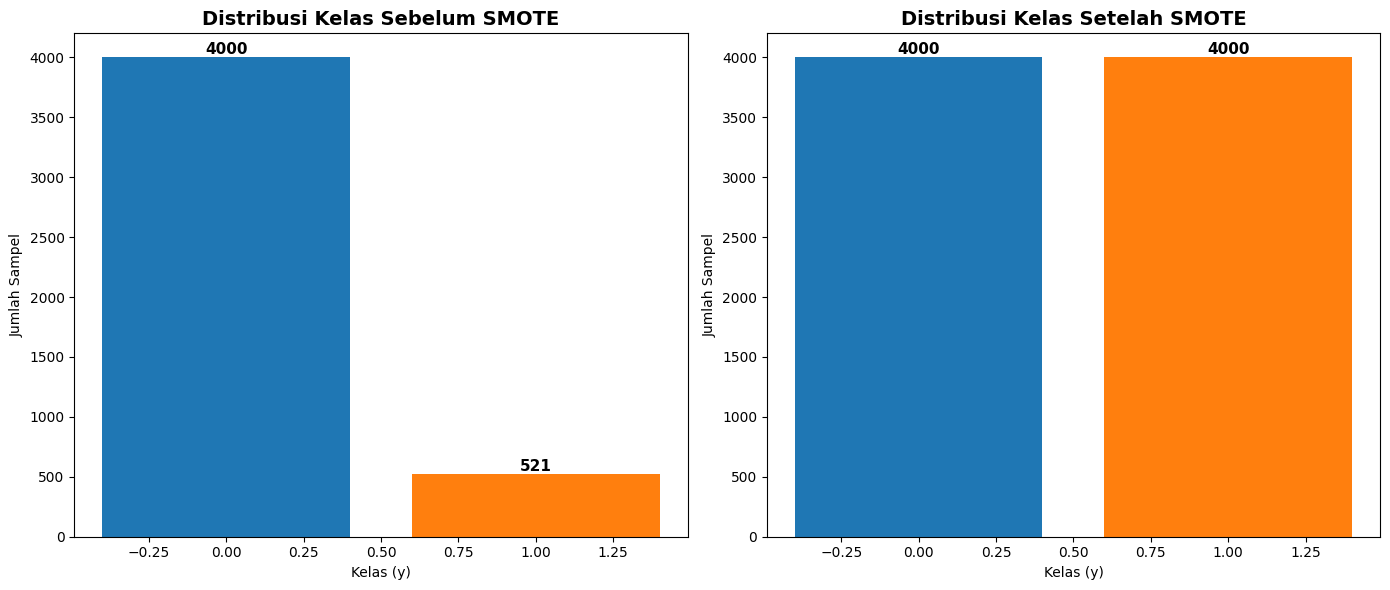


Tabel Perbandingan:
 Kelas  Sebelum SMOTE  Setelah SMOTE  Sampel Sintetis Ditambahkan
     0           4000           4000                            0
     1            521           4000                         3479


In [9]:
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd

# === VISUALISASI HASIL SMOTE ===
print("\n=== VISUALISASI HASIL SMOTE ===")

# Hitung distribusi kelas sebelum dan sesudah SMOTE
before_counts = Counter(y)
after_counts = Counter(y_resampled)

# Nama kelas (misalnya 'yes' dan 'no')
class_names = list(before_counts.keys())

# Nilai jumlah masing-masing kelas
before_values = [before_counts[c] for c in class_names]
after_values = [after_counts[c] for c in class_names]

# Buat subplot untuk perbandingan
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# --- Plot Sebelum SMOTE ---
bars1 = axes[0].bar(class_names, before_values, color=['#1f77b4', '#ff7f0e'])
axes[0].set_title('Distribusi Kelas Sebelum SMOTE', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Jumlah Sampel')
axes[0].set_xlabel('Kelas (y)')

# Tambahkan label di atas bar
for bar, value in zip(bars1, before_values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 str(value), ha='center', va='bottom', fontsize=11, fontweight='bold')

# --- Plot Setelah SMOTE ---
bars2 = axes[1].bar(class_names, after_values, color=['#1f77b4', '#ff7f0e'])
axes[1].set_title('Distribusi Kelas Setelah SMOTE', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Jumlah Sampel')
axes[1].set_xlabel('Kelas (y)')

# Tambahkan label di atas bar
for bar, value in zip(bars2, after_values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
                 str(value), ha='center', va='bottom', fontsize=11, fontweight='bold')

# Tata letak agar rapi
plt.tight_layout()
plt.show()

# === TABEL PERBANDINGAN ===
print("\nTabel Perbandingan:")
comparison_df = pd.DataFrame({
    'Kelas': class_names,
    'Sebelum SMOTE': before_values,
    'Setelah SMOTE': after_values,
    'Sampel Sintetis Ditambahkan': [
        after_values[i] - before_values[i] for i in range(len(class_names))
    ]
})

print(comparison_df.to_string(index=False))


#### - Klasifikasi Data menggunakan Bagging Classifier dan tanpa Bagging

In [1]:
import pandas as pd
import numpy as np
import mysql.connector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# --- 1. KONEKSI KE DATABASE ---
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="",        # ubah jika ada password
    database="bank"
)

# --- 2. AMBIL DATA DARI TABEL ---
query = "SELECT * FROM bank"
df = pd.read_sql(query, db)
print("Jumlah data:", len(df))
print(df.head())

# --- 3. ENCODING DATA KATEGORIK ---
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

# --- 4. PISAHKAN FITUR DAN TARGET ---
X = df.drop('y', axis=1)
y = df['y']

# --- 5. STANDARISASI DATA ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- 6. SPLIT DATA TRAIN-TEST ---
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# =====================
#   SEBELUM SMOTE
# =====================
print("\n=== KLASIFIKASI SEBELUM SMOTE ===")

# --- Naive Bayes ---
nb = GaussianNB()
nb.fit(X_train, y_train)
y_pred_nb = nb.predict(X_test)

print("\n[Naive Bayes - Sebelum SMOTE]")
print("Akurasi :", accuracy_score(y_test, y_pred_nb))
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

# --- SVM ---
svm = SVC(kernel='rbf', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

print("\n[SVM - Sebelum SMOTE]")
print("Akurasi :", accuracy_score(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# =====================
#   SESUDAH SMOTE
# =====================
print("\n=== KLASIFIKASI SESUDAH SMOTE ===")

sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# --- Naive Bayes ---
nb_smote = GaussianNB()
nb_smote.fit(X_res, y_res)
y_pred_nb_smote = nb_smote.predict(X_test)

print("\n[Naive Bayes - Setelah SMOTE]")
print("Akurasi :", accuracy_score(y_test, y_pred_nb_smote))
print(confusion_matrix(y_test, y_pred_nb_smote))
print(classification_report(y_test, y_pred_nb_smote))

# --- SVM ---
svm_smote = SVC(kernel='rbf', random_state=42)
svm_smote.fit(X_res, y_res)
y_pred_svm_smote = svm_smote.predict(X_test)

print("\n[SVM - Setelah SMOTE]")
print("Akurasi :", accuracy_score(y_test, y_pred_svm_smote))
print(confusion_matrix(y_test, y_pred_svm_smote))
print(classification_report(y_test, y_pred_svm_smote))


C:\Users\ahabi\AppData\Local\Temp\ipykernel_32900\4280578904.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, db)


Jumlah data: 4521
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  

=== KLASIFIKASI SEBELUM SMOTE ===

[Naive Bayes - Sebelum SMOTE]
Akurasi : 0.826086956521739

In [3]:
# === IMPORT LIBRARY ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
from collections import Counter

# Model & evaluasi
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from imblearn.over_sampling import SMOTE

# === 1. KONEKSI KE DATABASE & LOAD DATASET ===
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='',
    database='bank'  # ganti sesuai nama database kamu
)
df = pd.read_sql("SELECT * FROM bank", conn)   # tabel 'bank'
conn.close()

print(f"Jumlah data: {len(df)}")
print(df.head())

# === 2. PERSIAPAN DATA ===
# Encode semua kolom kategorikal
le = LabelEncoder()
for col in df.select_dtypes(include=['object']).columns:
    df[col] = le.fit_transform(df[col])

# Pisahkan fitur dan target
X = df.drop('y', axis=1)
y = df['y']

print("\nDistribusi kelas sebelum SMOTE:", Counter(y))

# === 3. SPLIT DATA SEBELUM SMOTE ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Standarisasi agar model SVM lebih stabil
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# === 4. KLASIFIKASI SEBELUM SMOTE (BAGGING) ===
print("\n=== KLASIFIKASI SEBELUM SMOTE (BAGGING) ===")

## Bagging + Naive Bayes
bag_nb = BaggingClassifier(estimator=GaussianNB(), n_estimators=10, random_state=42)
bag_nb.fit(X_train, y_train)
y_pred_nb = bag_nb.predict(X_test)
acc_nb_before = accuracy_score(y_test, y_pred_nb)

print("\n[Naive Bayes (Bagging) - Sebelum SMOTE]")
print(f"Akurasi : {acc_nb_before}")
print(confusion_matrix(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))

## Bagging + SVM
bag_svm = BaggingClassifier(estimator=SVC(kernel="linear", probability=True, random_state=42),
                            n_estimators=10, random_state=42)
bag_svm.fit(X_train, y_train)
y_pred_svm = bag_svm.predict(X_test)
acc_svm_before = accuracy_score(y_test, y_pred_svm)

print("\n[SVM (Bagging) - Sebelum SMOTE]")
print(f"Akurasi : {acc_svm_before}")
print(confusion_matrix(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))

# === 5. SMOTE ===
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
print("\nDistribusi kelas setelah SMOTE:", Counter(y_res))

# Split ulang data setelah SMOTE
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X_res, y_res, test_size=0.3, random_state=42, stratify=y_res
)

# Standarisasi ulang
X_train_res = scaler.fit_transform(X_train_res)
X_test_res = scaler.transform(X_test_res)

# === 6. KLASIFIKASI SETELAH SMOTE (BAGGING) ===
print("\n=== KLASIFIKASI SETELAH SMOTE (BAGGING) ===")

## Bagging + Naive Bayes
bag_nb_res = BaggingClassifier(estimator=GaussianNB(), n_estimators=10, random_state=42)
bag_nb_res.fit(X_train_res, y_train_res)
y_pred_nb_res = bag_nb_res.predict(X_test_res)
acc_nb_after = accuracy_score(y_test_res, y_pred_nb_res)

print("\n[Naive Bayes (Bagging) - Setelah SMOTE]")
print(f"Akurasi : {acc_nb_after}")
print(confusion_matrix(y_test_res, y_pred_nb_res))
print(classification_report(y_test_res, y_pred_nb_res))

## Bagging + SVM
bag_svm_res = BaggingClassifier(estimator=SVC(kernel="linear", probability=True, random_state=42),
                                n_estimators=10, random_state=42)
bag_svm_res.fit(X_train_res, y_train_res)
y_pred_svm_res = bag_svm_res.predict(X_test_res)
acc_svm_after = accuracy_score(y_test_res, y_pred_svm_res)

print("\n[SVM (Bagging) - Setelah SMOTE]")
print(f"Akurasi : {acc_svm_after}")
print(confusion_matrix(y_test_res, y_pred_svm_res))
print(classification_report(y_test_res, y_pred_svm_res))

# === 7. RINGKASAN PERBANDINGAN ===
results = pd.DataFrame({
    "Model": ["Naive Bayes (Bagging)", "Naive Bayes (Bagging)", "SVM (Bagging)", "SVM (Bagging)"],
    "Kondisi": ["Sebelum SMOTE", "Setelah SMOTE", "Sebelum SMOTE", "Setelah SMOTE"],
    "Akurasi": [acc_nb_before, acc_nb_after, acc_svm_before, acc_svm_after]
})

print("\n=== PERBANDINGAN AKURASI (BAGGING) ===")
print(results)


C:\Users\ahabi\AppData\Local\Temp\ipykernel_32900\3275926699.py:25: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM bank", conn)   # tabel 'bank'


Jumlah data: 4521
   age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no  

Distribusi kelas sebelum SMOTE: Counter({0: 4000, 1: 521})

=== KLASIFIKASI SEBELUM SMOTE (B